In [1]:
import pandas as pd
import geopandas as gpd
from functools import reduce
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Sample data for easier presentation are extracted from this step
02_IPUMS_DataCleaning.ipynb\
based on the results of Cell 7

In [2]:
### cell 7
# ### Create Hourly Columns from Departs/Arrives times
# ipums_df["DEPARTS_HOUR"] = ipums_df["DEPARTS"]//100
# ipums_df["ARRIVES_HOUR"] = ipums_df["ARRIVES"]//100

In [3]:
### just save the 2019 data
# ipums_df = ipums_df[ipums_df['YEAR']==2019].reset_index(drop=True)
# ipums_df.to_csv('ipums_original.csv',index=0)
# print(ipums_df.shape) (23139, 57)

In [4]:
### prepare some play data
ipums = pd.read_csv('ipums_original.csv')
health_cols = ['DIFFREM','DIFFPHYS','DIFFMOB','DIFFCARE','DIFFSENS','DIFFEYE','DIFFHEAR']
ipums = ipums[['PERWT','STATEFIP','PUMA','AGE','INCTOT','TRANWORK_HBDMATCH','ARRIVES_HOUR']+health_cols]
ipums[health_cols] = ipums[health_cols].replace({"No":0,"Yes":1})
ipums['DIFF'] = ipums['DIFFREM']+ipums['DIFFPHYS']+ipums['DIFFMOB']+ipums['DIFFCARE']+ipums['DIFFSENS']+ipums['DIFFEYE']+ipums['DIFFHEAR']
ipums = ipums.drop(health_cols, axis=1)
dist = pd.read_csv('puma_distance_centroid.csv')
dist = dist[['STATEFIP','PUMA','distance']]
ipums = ipums.merge(right=dist[['STATEFIP',"PUMA","distance"]],on=["STATEFIP","PUMA"],how='left')
ipums.rename({"TRANWORK_HBDMATCH":"TransMode","ARRIVES_HOUR":"Hour","distance":"DIST"},axis=1,inplace=True)
print(ipums['PERWT'].sum())
ipums

2671634.0


,PERWT,STATEFIP,PUMA,AGE,INCTOT,TransMode,Hour,DIFF,DIST
0,23.0,9,500,46,3800,AutoOccupants,9,0,177.094712
1,48.0,9,500,51,488000,AutoOccupants,8,0,177.094712
2,54.0,9,500,44,438000,AutoOccupants,8,0,177.094712
3,29.0,9,500,28,20000,AutoOccupants,14,0,177.094712
4,33.0,9,500,66,727000,AutoOccupants,9,0,177.094712
...,...,...,...,...,...,...,...,...,...
23134,61.0,36,3806,68,760000,WFH,0,0,7.332132
23135,154.0,36,3806,36,47000,WFH,0,0,7.332132
23136,168.0,36,3806,36,17000,WFH,0,2,7.332132
23137,184.0,36,3806,46,45000,WFH,0,0,7.332132


## Commuter Model

**Logic 1**: use "buckets" from current data structures, i.e. treating all commuters as a group.
- Hard to determine how results overlap with each other
- Hard to combine multiple variables

**Logic 2**: use original IPUMS data before aggregation \
Each row represents a group of people who have the same attributes, and we also know the sample size (PERWT)

In [5]:
ipums.head(3)

,PERWT,STATEFIP,PUMA,AGE,INCTOT,TransMode,Hour,DIFF,DIST
0,23.0,9,500,46,3800,AutoOccupants,9,0,177.094712
1,48.0,9,500,51,488000,AutoOccupants,8,0,177.094712
2,54.0,9,500,44,438000,AutoOccupants,8,0,177.094712


*PERWT indicates how many persons in the U.S. population are represented by a given person in an IPUMS sample.*<br>
*It is generally a good idea to use PERWT when conducting a person-level analysis of any IPUMS sample.*

#### Overall Logic

![tmp_model](tmp_model.png)

**Advantages:**
- person-level analysis is good for spatiotemporal analysis changes, not only get a final number
- make spatial visualization much easier, and consistent from the start
**Possible Improvements:**
- In addition to binary (CAN/CANT), use possibilities to fill the table. 
- So when we run the 2nd simulation, 20 out 200 will not be completely equal random

### Bus "fake" simulation as an example

In [6]:
def fake_simulation(a,b,c):
    ipums['Bus_Y_N'] = np.nan
    a = int(a)
    b = int(b)
    if c=='N':
        ipums.loc[(ipums['DIST']<=a) & (ipums['INCTOT']>=b*12*0.1) & (ipums['DIFF']<1),'Bus_Y_N'] = 1
        ipums['Bus_Y_N'] = ipums['Bus_Y_N'].fillna(0)
    elif c=='Y':
        ipums.loc[(ipums['DIST']<=a) & (ipums['INCTOT']>=b*12*0.1),'Bus_Y_N'] = 1
        ipums['Bus_Y_N'] = ipums['Bus_Y_N'].fillna(0)
    else:
        print('Wrong input for "Disabled friendly?"')
    
    all_commuter = int(ipums['PERWT'].sum())
    max_bus = int(ipums[ipums['Bus_Y_N']==1]['PERWT'].sum())
    current = int(ipums[ipums['TransMode']=='Bus']['PERWT'].sum())
    autos = int(ipums[ipums['TransMode']=='AutoOccupants']['PERWT'].sum())
    autos_bus = ipums[(ipums['TransMode']=='AutoOccupants')&(ipums['Bus_Y_N']==1)]['PERWT'].sum()
    
    dis_all = int(ipums[ipums['DIST']<a]['PERWT'].sum())
    dis_bus = int(ipums[(ipums['DIST']<a)&(ipums['TransMode']=='Bus')]['PERWT'].sum())
    
    print('='*80)
    print(' ~~~~~ Distance ~~~~~ ')
    print('{}% people are commuting at a distance less than {} km'.format(int((dis_all/all_commuter)*100), a))  
    print('{}% bus commuters are commuting at a distance less than {} km'.format(int((dis_bus/current)*100), a))  
    
    print('-'*80)
    print(' ~~~~~ Bus Simulation ~~~~~ ')
    if max_bus > current:
        print('Your input incentives will INCREASE the number of bus commuters.')
    elif max_bus < current:
        print('Your input incentives will DECREASE the number of bus commuters')
    else:
        print('Your input incentives will NOT change the number of bus commuters')
    print('The current bus commuters (IPUMS): {} {}%'.format(current, int((current/all_commuter)*100)))
    print('Max bus commuters based on current conditions: {} {}%'.format(max_bus, int((max_bus/all_commuter)*100)))        
    
    print('-'*80)
    print(' ~~~~~ Example Questions ~~~~~ ')
    print('Of the current {} Autos commuters, {}% have the conditions to switch to electric bus'.format(autos, int((autos_bus/autos)*100)))        
    
    print('-'*80)
    print('Your 24-hour simulation result is as follows.')
    
    ipums_agg = ipums.groupby(by=['TransMode','Hour']).agg({"PERWT":"sum"}).reset_index()
    ipums_agg_all = ipums.groupby(by=['Hour']).agg({"PERWT":"sum"}).reset_index()
    ipums_agg_new = ipums.groupby(by=['Bus_Y_N','Hour']).agg({"PERWT":"sum"}).reset_index()
    
    fig,ax=plt.subplots(figsize=(8,6))
    plt.grid()
    plt.title('This is a fake simulation')
    sns.lineplot(data=ipums_agg_all,x='Hour',y='PERWT',marker='o',label='ALL_commuters',ax=ax)
    sns.lineplot(data=ipums_agg[ipums_agg['TransMode']=='Bus'],x='Hour',y='PERWT',marker='o',label='Bus_Current',ax=ax)
    sns.lineplot(data=ipums_agg_new[ipums_agg_new['Bus_Y_N']==1],x='Hour',y='PERWT',label='Bus_MaxSimulation',marker='o',ax=ax)

The longest bus commuting distance (km): 10
Max commuting cost per month ($): 100
Disabled friendly? (Y/N): N


 ~~~~~ Distance ~~~~~ 
34% people are commuting at a distance less than 10 km
23% bus commuters are commuting at a distance less than 10 km
--------------------------------------------------------------------------------
 ~~~~~ Bus Simulation ~~~~~ 
Your input incentives will INCREASE the number of bus commuters.
The current bus commuters (IPUMS): 296874 11%
Max bus commuters based on current conditions: 896592 33%
--------------------------------------------------------------------------------
 ~~~~~ Example Questions ~~~~~ 
Of the current 328247 Autos commuters, 17% have the conditions to switch to electric bus
--------------------------------------------------------------------------------
Your 24-hour simulation result is as follows.


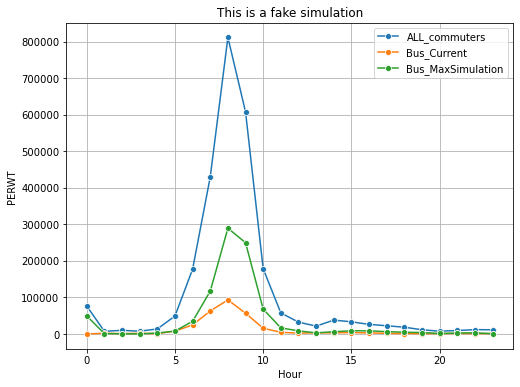

In [8]:
a = input("The longest bus commuting distance (km):")
b = input("Max commuting cost per month ($):")
c = input("Disabled friendly? (Y/N):")
fake_simulation(a,b,c)

In [9]:
ipums[['PERWT','Bus_Y_N']].astype(int)

,PERWT,Bus_Y_N
0,23,0
1,48,0
2,54,0
3,29,0
4,33,0
...,...,...
23134,61,1
23135,154,1
23136,168,0
23137,184,1
